# Data Loading

In [1]:
import warnings
import pandas as pd
import numpy as np
from scipy.io import arff
from pathlib import Path

warnings.filterwarnings("ignore")
pd.set_option("styler.render.max_columns", 200)

def convert_to_csv(file_path):
  old_filename = Path(file_path).stem
  new_filename = Path(old_filename).with_suffix(".csv")

  data, _ = arff.loadarff(file_path)
  df = pd.DataFrame(data)

  df = df.map(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)
  df.columns = df.columns.str.upper()
  df.replace("?", np.nan, inplace=True)

  df.to_csv(new_filename, index=False)

OLD_FILENAME = "hepatitis.arff"
NEW_FILENAME = "hepatitis.csv"

convert_to_csv(OLD_FILENAME)
df = pd.read_csv(NEW_FILENAME)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AGE              155 non-null    float64
 1   SEX              155 non-null    object 
 2   STEROID          154 non-null    object 
 3   ANTIVIRALS       155 non-null    object 
 4   FATIGUE          154 non-null    object 
 5   MALAISE          154 non-null    object 
 6   ANOREXIA         154 non-null    object 
 7   LIVER_BIG        145 non-null    object 
 8   LIVER_FIRM       144 non-null    object 
 9   SPLEEN_PALPABLE  150 non-null    object 
 10  SPIDERS          150 non-null    object 
 11  ASCITES          150 non-null    object 
 12  VARICES          150 non-null    object 
 13  BILIRUBIN        149 non-null    float64
 14  ALK_PHOSPHATE    126 non-null    float64
 15  SGOT             151 non-null    float64
 16  ALBUMIN          139 non-null    float64
 17  PROTIME         

In [2]:
df.head().T

,0,1,2,3,4
AGE,30.0,50.0,78.0,31.0,34.0
SEX,male,female,female,female,female
STEROID,no,no,yes,NaN,yes
ANTIVIRALS,no,no,no,yes,no
FATIGUE,no,yes,yes,no,no
MALAISE,no,no,no,no,no
ANOREXIA,no,no,no,no,no
LIVER_BIG,no,no,yes,yes,yes
LIVER_FIRM,no,no,no,no,no
SPLEEN_PALPABLE,no,no,no,no,no


# Exploratory Data Analysis

## Statistics

Average age of patients who died from hepatitis:

In [3]:
df[df["CLASS"] == "DIE"]["AGE"].mean().round()

np.float64(47.0)

Gender of patients who died from hepatitis. It appears to be imbalanced, containing only female records.

In [4]:
df[df["CLASS"] == "DIE"]["SEX"].value_counts()

,count
SEX,
female,32


Most patients who died from hepatitis experienced fatigue.

In [5]:
((df["CLASS"] == "DIE") & (df["FATIGUE"] == "yes")).sum() / (df["CLASS"] == "DIE").sum() * 100

np.float64(93.75)

BILIBURIN, ALK_PHOSPHATE, and SGOT appear to be heavily right-skewed.

In [6]:
df[df["CLASS"] == "DIE"][["BILIRUBIN", "ALK_PHOSPHATE", "SGOT", "ALBUMIN", "PROTIME"]].describe()

,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME
count,30.000000,24.000000,30.000000,27.000000,18.000000
mean,2.543333,122.375000,99.833333,3.151852,43.500000
std,1.940082,54.348963,101.768189,0.602157,16.762177
min,0.400000,62.000000,16.000000,2.100000,29.000000
25%,1.200000,84.750000,48.250000,2.650000,31.250000
50%,1.950000,113.500000,66.000000,3.300000,39.000000
75%,3.650000,142.250000,118.500000,3.550000,45.250000
max,8.000000,280.000000,528.000000,4.200000,90.000000


Survival is more common than death among anorexic patients.

In [7]:
df[df["ANOREXIA"] == "yes"]["CLASS"].value_counts(normalize=True) * 100


,proportion
CLASS,
LIVE,68.75
DIE,31.25


Patients with big liver are more likely to die from hepatitis than those with firm liver.

In [8]:
die_with_liver_big = df[df["LIVER_BIG"] == "yes"]["CLASS"].value_counts()["DIE"]
die_with_liver_firm = df[df["LIVER_FIRM"] == "yes"]["CLASS"].value_counts()["DIE"]
display(die_with_liver_big, die_with_liver_firm)

np.int64(24)

np.int64(13)

## Correlation

ALBUMIN and ALK_PHOSPHATE/BILIRUBIN show negative correlation. In contrast, ALBUMIN and PROTIME are positively correlated.

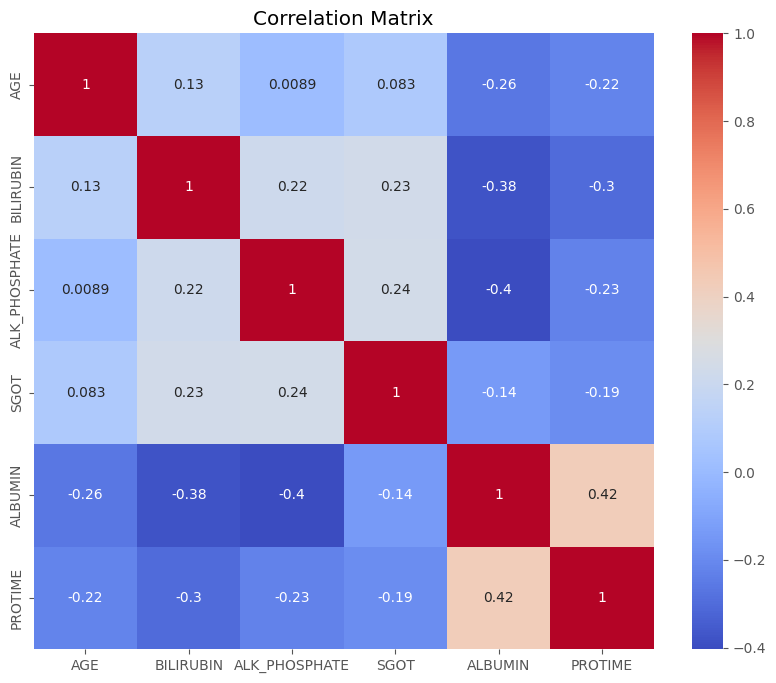

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")

corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=True)
plt.title("Correlation Matrix")
plt.show()

## Nulls

PROTIME has the highest proportion of missing values.

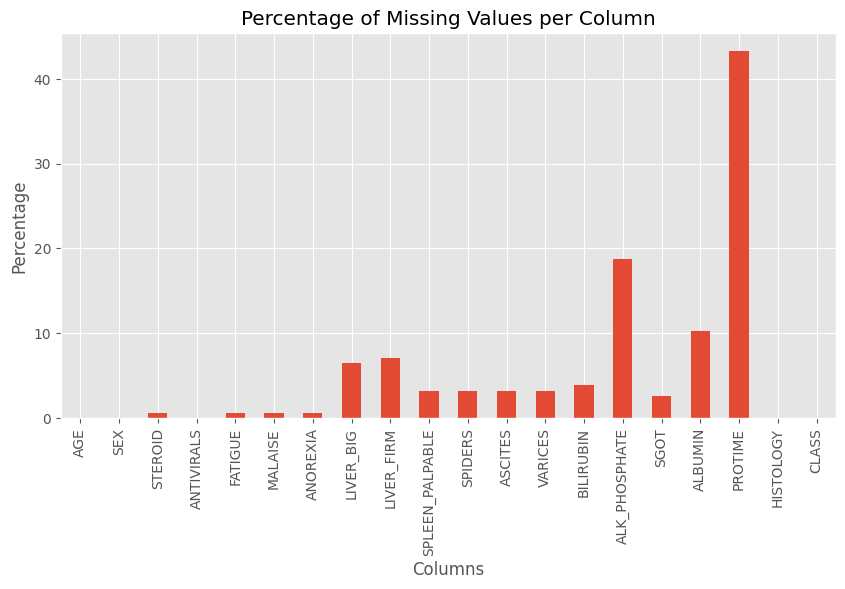

In [10]:
missing_pct = df.isnull().mean() * 100

plt.figure(figsize=(10, 5))
missing_pct.plot(kind='bar')
plt.title("Percentage of Missing Values per Column")
plt.ylabel("Percentage")
plt.xlabel("Columns")
plt.show()

PROTIME missingness pattern does not affect CLASS.

In [11]:
df["CLASS"] = df["CLASS"].map({"LIVE": 1, "DIE": 0})

df.groupby(df["PROTIME"].isna())["CLASS"].mean()

,CLASS
PROTIME,
False,0.795455
True,0.791045


## Distributions

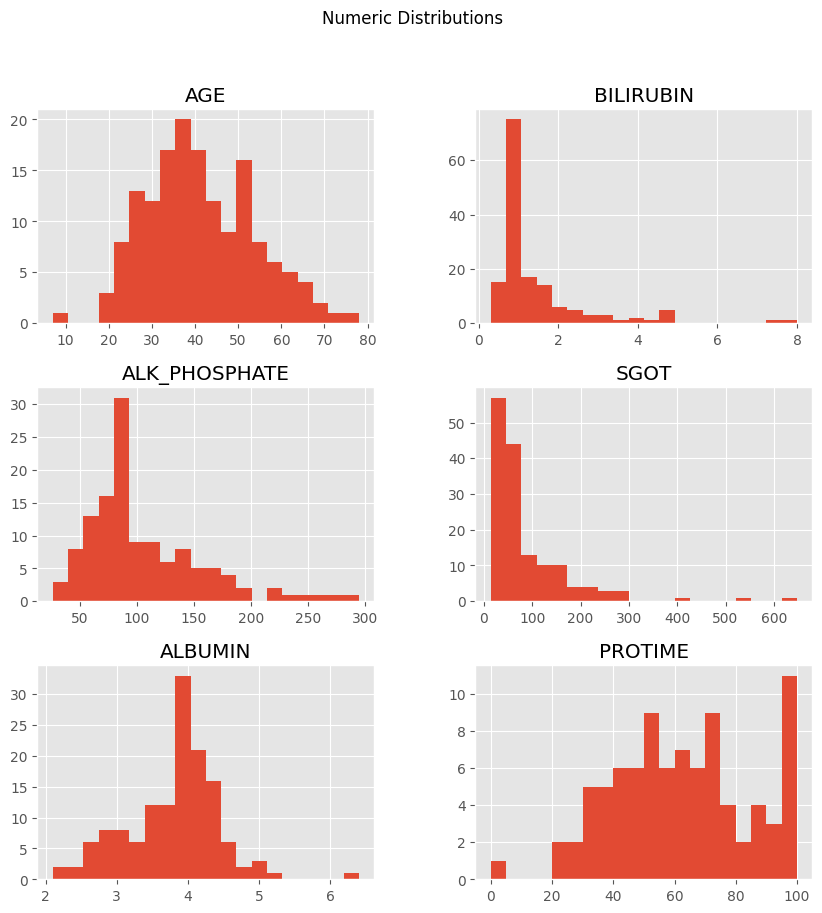

In [12]:
num_cols = df.select_dtypes(include=["float64"]).columns

df[num_cols].hist(figsize=(10, 10), bins=20)
plt.suptitle("Numeric Distributions")
plt.show()

SEX contains far more female records than male. CLASS is biased towards LIVE samples.

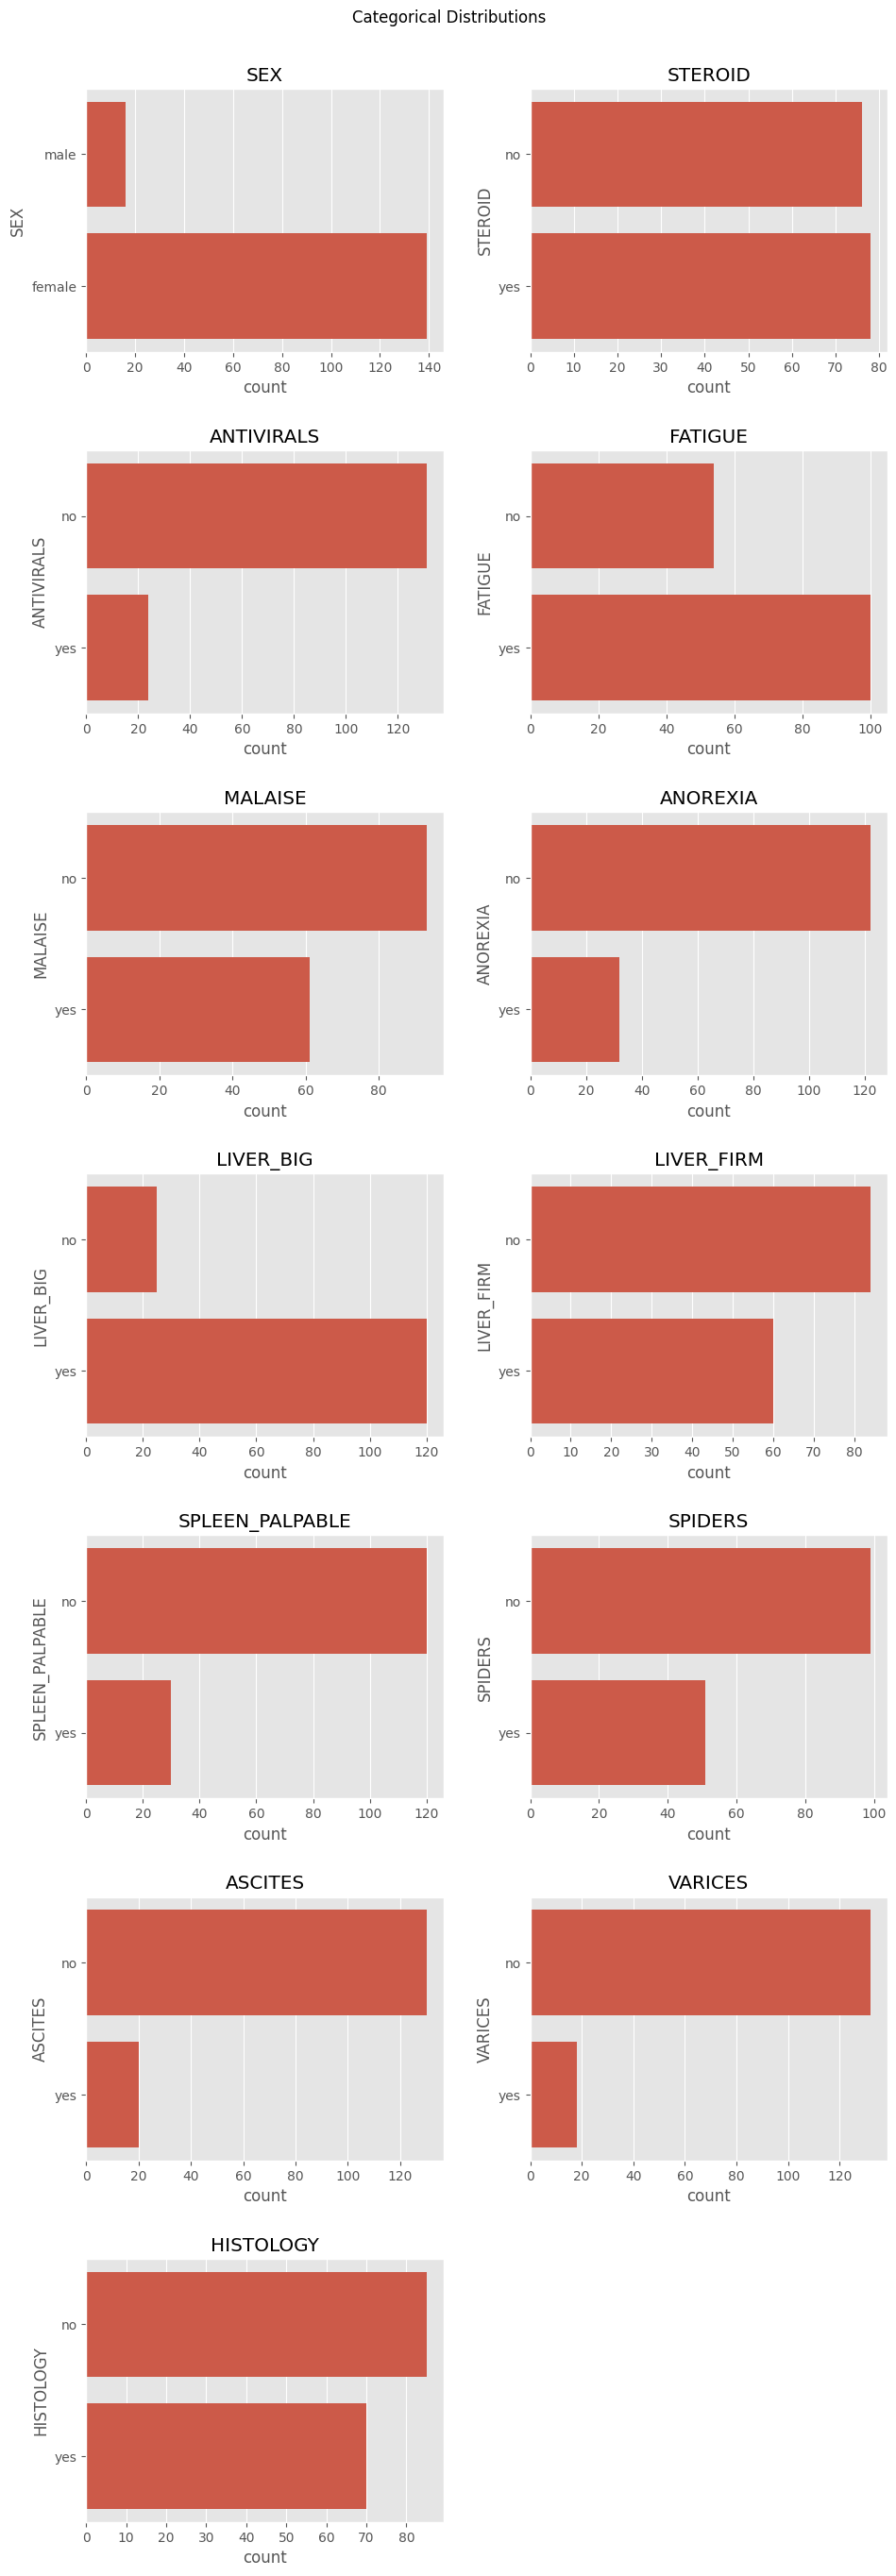

In [13]:
cat_cols = df.select_dtypes(include=["object"]).columns

N = len(cat_cols)
COLS = 2
ROWS = (N + COLS - 1) // COLS
plt.figure(figsize=(10, 4 * ROWS))

for i, col in enumerate(cat_cols, 1):
  plt.subplot(ROWS, COLS, i)
  sns.countplot(data=df, y=col)
  plt.title(col)

plt.suptitle("Categorical Distributions")
plt.tight_layout(pad=2.5)
plt.subplots_adjust(top=0.95)
plt.show()

Imbalance dataset with dominance of LIVE class.

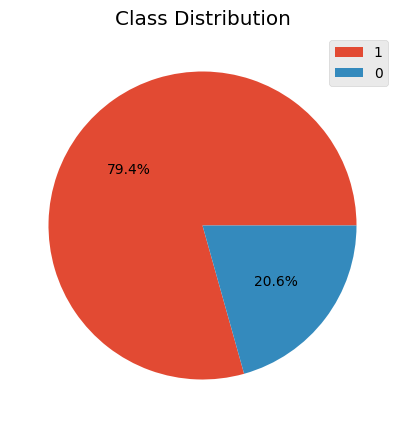

In [14]:
class_counts = df["CLASS"].value_counts()

plt.figure(figsize=(10, 5))

plt.pie(class_counts, autopct="%1.1f%%")
plt.title("Class Distribution")
plt.legend(class_counts.index)
plt.show()

Patients who died from hepatitis tend to be older.

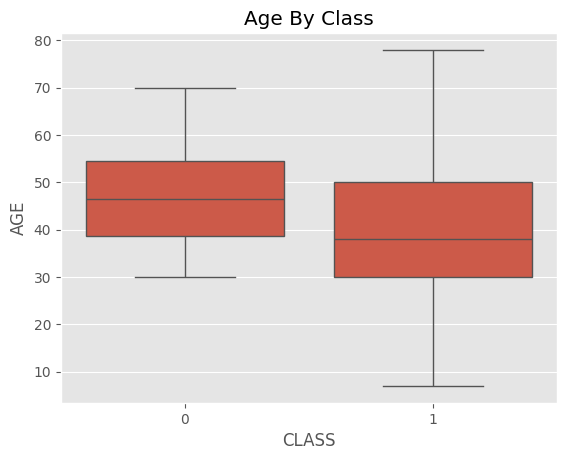

In [15]:
sns.boxplot(x="CLASS", y="AGE", data=df)
plt.title("Age By Class")
plt.show()

Patients with high BILIRUBIN have a significant chance of death from hepatitis.

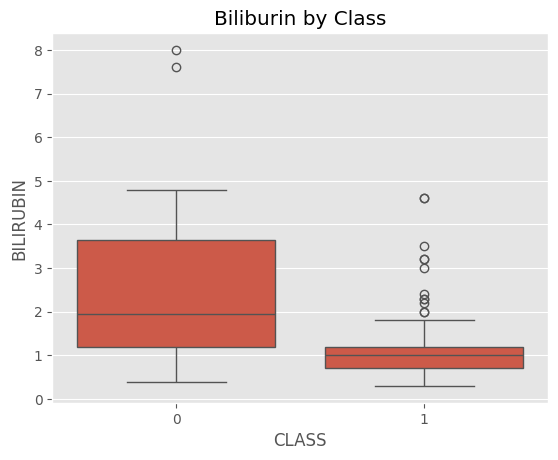

In [16]:
sns.boxplot(x="CLASS", y="BILIRUBIN", data=df)
plt.title("Biliburin by Class")
plt.show()

In general, patients who received STERIOD or ANTIVIRALS have higher chances of survival from hepatitis.

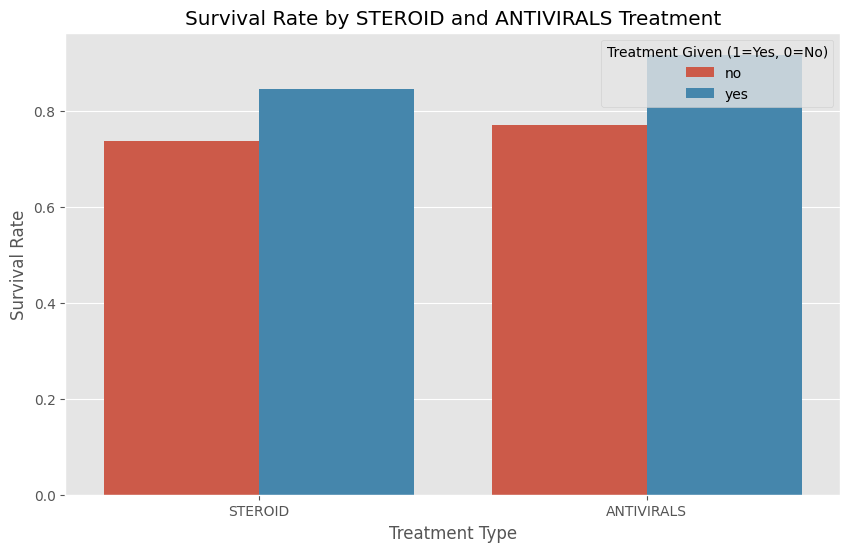

In [17]:
steroid_survival = df.groupby("STEROID")["CLASS"].mean().reset_index()
steroid_survival["Treatment"] = "STEROID"
steroid_survival.rename(columns={"STEROID": "Value", "CLASS": "SurvivalRate"}, inplace=True)

antivirals_survival = df.groupby("ANTIVIRALS")["CLASS"].mean().reset_index()
antivirals_survival["Treatment"] = "ANTIVIRALS"
antivirals_survival.rename(columns={"ANTIVIRALS": "Value", "CLASS": "SurvivalRate"}, inplace=True)

combined_survival = pd.concat([steroid_survival, antivirals_survival], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=combined_survival, x="Treatment", y="SurvivalRate", hue="Value")
plt.title("Survival Rate by STEROID and ANTIVIRALS Treatment")
plt.xlabel("Treatment Type")
plt.ylabel("Survival Rate")
plt.legend(title="Treatment Given (1=Yes, 0=No)")
plt.show()

# Data Preparation

In [18]:
df.isnull().mean() * 100

,0
AGE,0.000000
SEX,0.000000
STEROID,0.645161
ANTIVIRALS,0.000000
FATIGUE,0.645161
MALAISE,0.645161
ANOREXIA,0.645161
LIVER_BIG,6.451613
LIVER_FIRM,7.096774
SPLEEN_PALPABLE,3.225806


In [19]:
for col in df.columns:
    if col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    elif col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

In [20]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


In [21]:
print("Unique values for categorical columns:")
for col in cat_cols:
    print(f"{col}: {df[col].unique()}")

Unique values for categorical columns:
SEX: ['male' 'female']
STEROID: ['no' 'yes']
ANTIVIRALS: ['no' 'yes']
FATIGUE: ['no' 'yes']
MALAISE: ['no' 'yes']
ANOREXIA: ['no' 'yes']
LIVER_BIG: ['no' 'yes']
LIVER_FIRM: ['no' 'yes']
SPLEEN_PALPABLE: ['no' 'yes']
SPIDERS: ['no' 'yes']
ASCITES: ['no' 'yes']
VARICES: ['no' 'yes']
HISTOLOGY: ['no' 'yes']


In [22]:
from sklearn.preprocessing import OneHotEncoder

def get_feature_name_out(feature, category):
    return f"{feature}_{category.upper()}"

encoder = OneHotEncoder(
    drop="first",
    sparse_output=False,
    feature_name_combiner=get_feature_name_out
)
one_hot_encoded = encoder.fit_transform(df[cat_cols])
one_hot_df = pd.DataFrame(
    index=df.index,
    data=one_hot_encoded,
    columns=encoder.get_feature_names_out(cat_cols)
)
df = pd.concat([df, one_hot_df], axis=1)
df.drop(columns=cat_cols, axis=1, inplace=True)

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols_for_scaling = ["BILIRUBIN", "ALK_PHOSPHATE", "SGOT", "PROTIME"]
df[cols_for_scaling] = scaler.fit_transform(df[cols_for_scaling])

In [24]:
symptom_cols = ["FATIGUE_YES", "MALAISE_YES", "ANOREXIA_YES", "LIVER_BIG_YES", "LIVER_FIRM_YES",
                "SPLEEN_PALPABLE_YES", "SPIDERS_YES", "ASCITES_YES", "VARICES_YES"]

df["SYMPTOM_SCORE"] = df[symptom_cols].sum(axis=1)

In [25]:
df.head().T

,0,1,2,3,4
AGE,30.000000,50.000000,78.000000,31.000000,34.000000
BILIRUBIN,-0.346128,-0.430351,-0.598796,-0.598796,-0.346128
ALK_PHOSPHATE,-0.352069,0.713349,-0.117677,-1.183096,-0.352069
SGOT,-0.760716,-0.488927,-0.602173,-0.375682,1.300348
ALBUMIN,4.000000,3.500000,4.000000,4.000000,4.000000
PROTIME,-0.028225,-0.028225,-0.028225,1.080087,-0.028225
CLASS,1.000000,1.000000,1.000000,1.000000,1.000000
SEX_MALE,1.000000,0.000000,0.000000,0.000000,0.000000
STEROID_YES,0.000000,0.000000,1.000000,1.000000,1.000000
ANTIVIRALS_YES,0.000000,0.000000,0.000000,1.000000,0.000000


In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

SEED = 67

X, y = df.drop("CLASS", axis=1), df["CLASS"]
smote = SMOTE(
    k_neighbors=3,
    random_state=SEED,
    sampling_strategy="minority"
)

X_resampled, y_resampled = smote.fit_resample(X, y)
print("Distribution of classes after SMOTE:")
print(y_resampled.value_counts(), end="\n\n")

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=SEED
)

print("Split to training and testing sets.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Distribution of classes after SMOTE:
CLASS
1    123
0    123
Name: count, dtype: int64

Split to training and testing sets.
Shape of X_train: (196, 20)
Shape of X_test: (50, 20)
Shape of y_train: (196,)
Shape of y_test: (50,)


# Model Training

In [27]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

def get_scoring(test, pred):
  accuracy = accuracy_score(test, pred)
  precision = precision_score(test, pred)
  recall = recall_score(test, pred)
  f1 = f1_score(test, pred)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-Score: {f1:.4f}")


def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(6,4))
  sns.heatmap(cm, cmap="coolwarm", annot=True, fmt=".2f")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

## Logistic Regression

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
from sklearn.linear_model import LogisticRegression

params = {
    "C": [1, 2, 3],
    "penalty": ["l1", "l2"],
    "max_iter": [100, 200, 300],
}

lr = LogisticRegression(
    solver="liblinear",
    class_weight="balanced",
    random_state=SEED
)
grid_lr = GridSearchCV(lr, params, cv=5, verbose=2, scoring="f1")
grid_lr.fit(X_train, y_train)

print(f"Best params: {grid_lr.best_params_}")
print(f"Best score: {grid_lr.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ......................C=1, max_iter=100, penalty=l1; total time=   0.0s
[CV] END ......................C=1, max_iter=100, penalty=l1; total time=   0.0s
[CV] END ......................C=1, max_iter=100, penalty=l1; total time=   0.0s
[CV] END ......................C=1, max_iter=100, penalty=l1; total time=   0.0s
[CV] END ......................C=1, max_iter=100, penalty=l1; total time=   0.0s
[CV] END ......................C=1, max_iter=100, penalty=l2; total time=   0.0s
[CV] END ......................C=1, max_iter=100, penalty=l2; total time=   0.0s
[CV] END ......................C=1, max_iter=100, penalty=l2; total time=   0.0s
[CV] END ......................C=1, max_iter=100, penalty=l2; total time=   0.0s
[CV] END ......................C=1, max_iter=100, penalty=l2; total time=   0.0s
[CV] END ......................C=1, max_iter=200, penalty=l1; total time=   0.0s
[CV] END ......................C=1, max_iter=200

In [30]:
y_pred = grid_lr.predict(X_test)
get_scoring(y_test, y_pred)

Accuracy: 0.9200
Precision: 0.9524
Recall: 0.8696
F1-Score: 0.9091


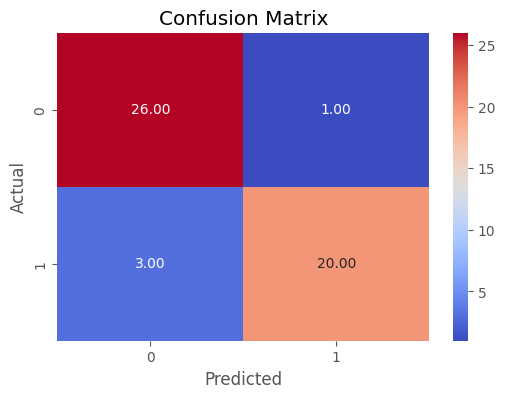

In [31]:
plot_confusion_matrix(y_test, y_pred)

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

params = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=SEED
)
grid_rf = GridSearchCV(rf, params, cv=5, verbose=2, n_jobs=-1, scoring="f1")
grid_rf.fit(X_train, y_train)

print(f"Best params: {grid_rf.best_params_}")
print(f"Best score: {grid_rf.best_score_}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.8897694797309688


In [33]:
y_pred = grid_rf.predict(X_test)
get_scoring(y_test, y_pred)

Accuracy: 0.8800
Precision: 0.8696
Recall: 0.8696
F1-Score: 0.8696


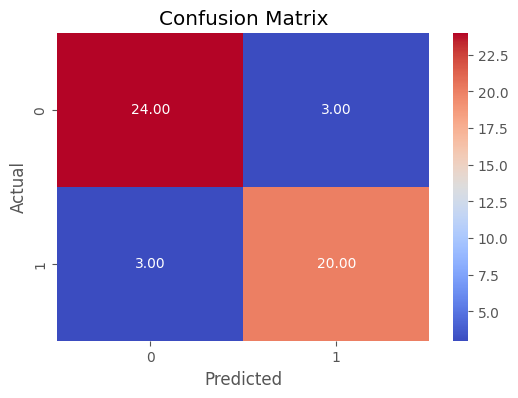

In [34]:
plot_confusion_matrix(y_test, y_pred)

## XGBoost

In [35]:
import xgboost as xgb

params = {
    "max_depth": [3, 5],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [0, 1],
    "n_estimators": [200, 400],
    "learning_rate": [0.05, 0.1],
    "colsample_bytree": [0.8, 1.0],
}

clf = xgb.XGBClassifier(
    subsample=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=SEED
)
grid_clf = GridSearchCV(clf, params, cv=5, verbose=2, n_jobs=-1, scoring="f1")
grid_clf.fit(X_train, y_train)

print(f"Best params: {grid_clf.best_params_}")
print(f"Best score: {grid_clf.best_score_}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda': 1}
Best score: 0.8922506827384875


In [36]:
y_pred = grid_clf.predict(X_test)
get_scoring(y_test, y_pred)

Accuracy: 0.8800
Precision: 0.9048
Recall: 0.8261
F1-Score: 0.8636


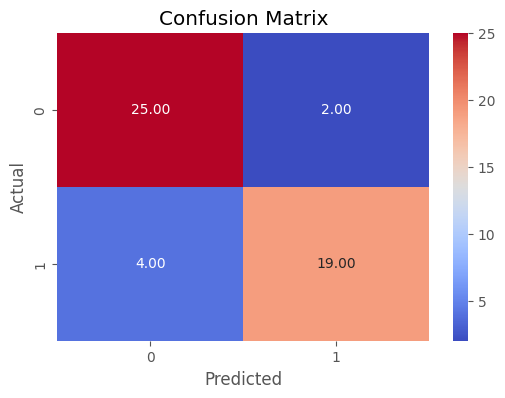

In [37]:
plot_confusion_matrix(y_test, y_pred)

In [38]:
import joblib

joblib.dump(grid_lr, "model.pkl")

['model.pkl']